# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT THÀNH PHỐ HỒ CHÍ MINH
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY ĐỂ DỰ ĐOÁN GIÁ NÔNG SẢN

Sinh viên 1: Huỳnh Hạo Nhị - 20133006

Sinh viên 2: Võ Hoài Thương - 20233012

# Thư viện

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go

# Dữ liệu

## Giá lúa nội địa

Dữ liệu giá lúa được thu thập của tỉnh An Giang, từ website của Viện Chính sách và Chiến lược Phát triển Nông nghiệp Nông thôn từ năm 2007 đến nay.
*   date*: ngày
*   price: giá lúa


In [ ]:
df_rice = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Lua/gia_lua.csv', encoding='ISO-8859-1')
df_rice.tail()

,date,price
6274,5/11/2024,16000
6275,5/12/2024,16000
6276,5/13/2024,16000
6277,5/14/2024,16000
6278,5/15/2024,16000


In [ ]:
df_rice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6279 entries, 0 to 6278
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    6279 non-null   object
 1   price   6279 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 98.2+ KB


In [ ]:
df_rice['date'] = pd.to_datetime(df_rice['date'])
df_rice.set_index('date', inplace=True)

### Điền dữ liệu ngày thiếu

In [ ]:
idx = pd.date_range(df_rice.index.min(), df_rice.index.max())
df_rice = df_rice.reindex(idx)
df_rice.fillna(method='ffill', inplace=True)
df_rice.tail()

,price
2024-05-11,16000
2024-05-12,16000
2024-05-13,16000
2024-05-14,16000
2024-05-15,16000


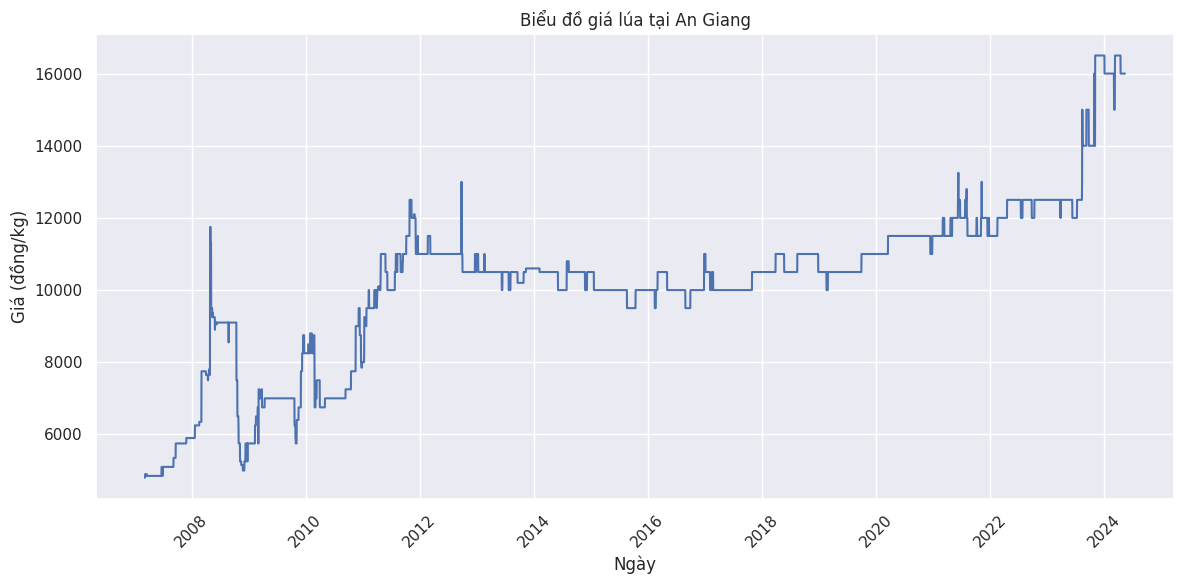

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_rice, x=df_rice.index, y='price')
plt.title('Biểu đồ giá lúa tại An Giang')
plt.xlabel('Ngày')
plt.ylabel('Giá (đồng/kg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Giá lúa xuất khẩu

Dữ liệu về giá trị xuất lúa được thu thập từ website của Viện Chính sách và Chiến lược Phát triển Nông nghiệp Nông thôn.
*   date*: ngày
*   volume: Khối lượng xuất khẩu (tấn)
*   value: Kim ngạch xuất khẩu (USD)
*   value/volume: Giá trị xuất khẩu (USD/tấn)



In [ ]:
df_rice_export = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Lua/xuat_khau_lua.csv', encoding='ISO-8859-1')
df_rice_export.head()

,date,volume,value,value/volume
0,11/1/2023,600481,400345332,666.707743
1,10/1/2023,635102,406762427,640.467873
2,9/1/2023,605410,377783375,624.012446
3,8/1/2023,921443,546405796,592.989253
4,7/1/2023,660738,362660136,548.871317


In [ ]:
df_rice_export['date'] = pd.to_datetime(df_rice_export['date'])
df_rice_export.set_index('date', inplace=True)

### Xử lý outlier

<Axes: >

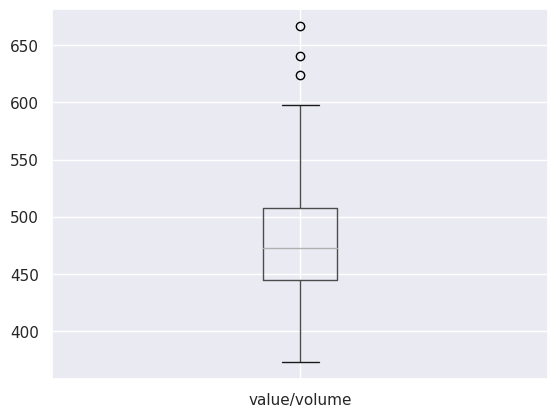

In [ ]:
df_rice_export[['value/volume']].boxplot()

In [ ]:
Q1 = df_rice_export['value/volume'].quantile(0.25)
Q3 = df_rice_export['value/volume'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
outliers = df_rice_export[(df_rice_export['value/volume'] < lower_bound) | (df_rice_export['value/volume'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

Số lượng outlier: 3


In [ ]:
df_rice_export.at[df_rice_export.index[0], 'value/volume'] = min(max(df_rice_export.iloc[0]['value/volume'], lower_bound), upper_bound)

for index, row in outliers.iterrows():
    previous_date_index = df_rice_export.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df_rice_export.index[previous_date_index]
        previous_value = df_rice_export.loc[previous_date, 'value/volume']
        df_rice_export.at[index, 'value/volume'] = previous_value

<Axes: >

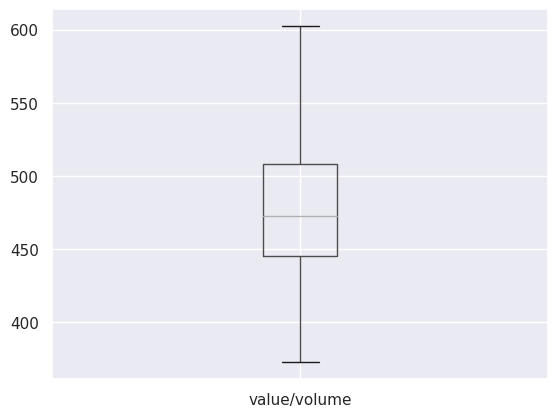

In [ ]:
df_rice_export[['value/volume']].boxplot()

### Fill dữ liệu ngày bị thiếu

In [ ]:
idx = pd.date_range(df_rice_export.index.min(), df_rice_export.index.max())
df_rice_export = df_rice_export.reindex(idx)

In [ ]:
df_rice_export.fillna(method='ffill', inplace=True)
df_rice_export.head()

,volume,value,value/volume
2010-01-01,379979.0,204550382.0,538.320228
2010-01-02,379979.0,204550382.0,538.320228
2010-01-03,379979.0,204550382.0,538.320228
2010-01-04,379979.0,204550382.0,538.320228
2010-01-05,379979.0,204550382.0,538.320228


### Merge dữ liệu xuất khẩu vào giá lúa

In [ ]:
start_date = df_rice_export.index.min()
df_rice_filtered = df_rice.loc[start_date:]

df_merged_rice_export = pd.merge(df_rice_filtered, df_rice_export[['value/volume']], left_index=True, right_index=True, how='left')
df_merged_rice_export['value/volume'] = df_merged_rice_export['value/volume'].ffill()

print(df_merged_rice_export.tail())

            price  value/volume
2024-05-11  16000    602.453247
2024-05-12  16000    602.453247
2024-05-13  16000    602.453247
2024-05-14  16000    602.453247
2024-05-15  16000    602.453247


In [ ]:
# df_merged_rice_export.to_csv('coffee_export.csv', index=True)

### Làm mịn dữ liệu

In [ ]:
df_merged_rice_export = df_merged_rice_export.rolling(window=60, min_periods=1).mean()

## Giá xăng

Dữ liệu giá xăng thu thập từ website của Công ty Dầu Việt Nam – CTCP.
*   date*: ngày
*   RON 95-III: giá xăng Ron 95-III

In [ ]:
df_gasoline = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Xang/gia_xang.csv', encoding='ISO-8859-1')
df_gasoline.tail()

,date,RON 95-III
170,2/5/2024,24.95
171,9/5/2024,23.54
172,16/05/2024,23.13
173,23/05/2024,23.21
174,29/05/2024,23.21


### Xử lý outlier

<Axes: >

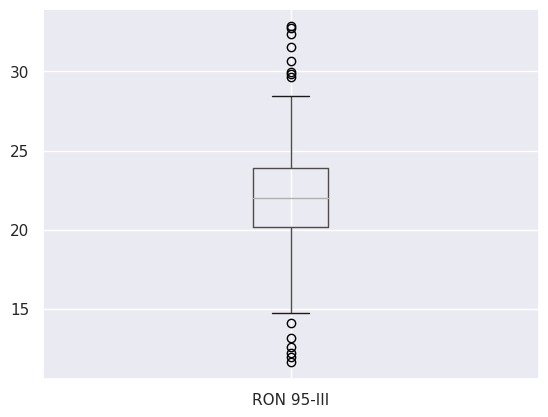

In [ ]:
df_gasoline[['RON 95-III']].boxplot()

In [ ]:
Q1 = df_gasoline['RON 95-III'].quantile(0.25)
Q3 = df_gasoline['RON 95-III'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
outliers = df_gasoline[(df_gasoline['RON 95-III'] < lower_bound) | (df_gasoline['RON 95-III'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

Số lượng outlier: 14


In [ ]:
df_gasoline.at[df_gasoline.index[0], 'RON 95-III'] = min(max(df_gasoline.iloc[0]['RON 95-III'], lower_bound), upper_bound)

for index, row in outliers.iterrows():
    previous_date_index = df_gasoline.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df_gasoline.index[previous_date_index]
        previous_value = df_gasoline.loc[previous_date, 'RON 95-III']
        df_gasoline.at[index, 'RON 95-III'] = previous_value

<Axes: >

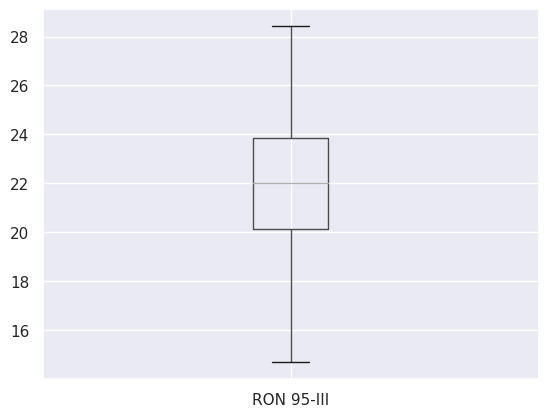

In [ ]:
df_gasoline[['RON 95-III']].boxplot()

### Fill dữ liệu ngày bị thiếu

In [ ]:
df_gasoline['date'] = pd.to_datetime(df_gasoline['date'])
df_gasoline.set_index('date', inplace=True)

<ipython-input-34-2ca4586e2886>:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_gasoline['date'] = pd.to_datetime(df_gasoline['date'])


In [ ]:
idx = pd.date_range(df_gasoline.index.min(), df_gasoline.index.max())
df_gasoline = df_gasoline.reindex(idx)
df_gasoline.fillna(method='ffill', inplace=True)

### Merge dữ liệu xăng với giá lúa

In [ ]:
start_date = df_gasoline.index.min()
df_rice_filtered = df_rice.loc[start_date:]

df_merged_gasoline = pd.merge(df_rice_filtered, df_gasoline[['RON 95-III']], left_index=True, right_index=True, how='left')
df_merged_gasoline['RON 95-III'] = df_merged_gasoline['RON 95-III'].ffill()

print(df_merged_gasoline.tail())

            price  RON 95-III
2024-05-11  16000       23.54
2024-05-12  16000       23.54
2024-05-13  16000       23.54
2024-05-14  16000       23.54
2024-05-15  16000       23.54


In [ ]:
# df_merged_gasoline.to_csv('coffee_gasoline.csv', index=True)

### Làm mịn dữ liệu

In [ ]:
df_merged_gasoline = df_merged_gasoline.rolling(window=30, min_periods=1).mean()

# Mô hình GRU dự đoán

Gated Recurrent Unit (GRU)  là mạng nơ-ron hồi quy có khả năng xử lý chuỗi thời gian dài hạn, là biến thể đơn giản hóa từ Long Short-Term Memory (LSTM) với cấu trúc gồm hai cổng:
*   Cổng đặt lại (r): xác định phần thông tin của trạng thái ẩn trước cần loại bỏ bằng hàm sigmoid.
*   Cổng cập nhật (z): xác định thông tin nào từ trạng thái ẩn trước được giữ lại và thông tin mới nào sẽ được thêm vào bằng hàm sigmoid.
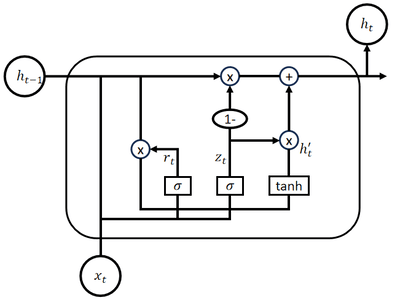

## Kết hợp giá lúa, xuất khẩu, giá xăng

### Xây dựng mô hình

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
start_date = df_gasoline.index.min()
df_rice_filtered = df_rice.loc[start_date:]

df_rice_merged = pd.merge(df_rice_filtered, df_rice_export[['value/volume']], left_index=True, right_index=True, how='left')
df_rice_merged['value/volume'] = df_rice_merged['value/volume'].ffill()

df_rice_merged = pd.merge(df_rice_merged, df_gasoline[['RON 95-III']], left_index=True, right_index=True, how='left')
df_rice_merged['RON 95-III'] = df_rice_merged['RON 95-III'].ffill()

print(df_rice_merged.tail())

            price  value/volume  RON 95-III
2024-05-11  16000    602.453247       23.54
2024-05-12  16000    602.453247       23.54
2024-05-13  16000    602.453247       23.54
2024-05-14  16000    602.453247       23.54
2024-05-15  16000    602.453247       23.54


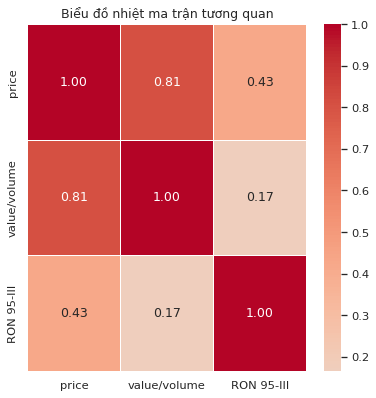

In [ ]:
correlation_matrix = df_rice_merged.corr()

plt.figure(figsize=(6, 6), dpi=75)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=.5, cmap='coolwarm', center=0)
plt.title('Biểu đồ nhiệt ma trận tương quan')
plt.show()

In [ ]:
df_rice_merged = df_rice_merged.rolling(window=30, min_periods=1).mean()

In [ ]:
# df_coffee_merged.to_csv('coffee_merged.csv', index=True)

In [ ]:
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler_price.fit_transform(df_rice_merged[['price']])

scaler_export = MinMaxScaler(feature_range=(0, 1))
scaled_export = scaler_export.fit_transform(df_rice_merged[['value/volume']])

scaler_gasoline = MinMaxScaler(feature_range=(0, 1))
scaler_gasoline = scaler_gasoline.fit_transform(df_rice_merged[['RON 95-III']])

scaled_data = np.concatenate((scaled_price, scaled_export), axis=1)
scaled_data = np.concatenate((scaled_data, scaler_gasoline), axis=1)

In [ ]:
seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

In [ ]:
X.shape, y.shape

((2064, 30, 3), (2064,))

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)

Kích thước tập huấn luyện: (1651, 30, 3) (1651,)
Kích thước tập kiểm tra: (413, 30, 3) (413,)


In [ ]:
model = Sequential()
model.add(GRU(units=128, input_shape=(seq_length, 3)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
26/26 [==============================] - 5s 49ms/step - loss: 0.0125
Epoch 2/50
26/26 [==============================] - 1s 50ms/step - loss: 0.0030
Epoch 3/50
26/26 [==============================] - 1s 54ms/step - loss: 0.0014
Epoch 4/50
26/26 [==============================] - 1s 54ms/step - loss: 8.9588e-04
Epoch 5/50
26/26 [==============================] - 1s 53ms/step - loss: 6.9155e-04
Epoch 6/50
26/26 [==============================] - 2s 61ms/step - loss: 5.6911e-04
Epoch 7/50
26/26 [==============================] - 2s 59ms/step - loss: 5.2929e-04
Epoch 8/50
26/26 [==============================] - 3s 114ms/step - loss: 4.5899e-04
Epoch 9/50
26/26 [==============================] - 3s 119ms/step - loss: 4.5122e-04
Epoch 10/50
26/26 [==============================] - 2s 57ms/step - loss: 3.8904e-04
Epoch 11/50
26/26 [==============================] - 1s 45ms/step - loss: 3.4188e-04
Epoch 12/50
26/26 [==============================] - 1s 46ms/step - loss: 3.2366e-04

### Dự đoán trên tập train

In [ ]:
train_predictions = model.predict(X_train)

52/52 [==============================] - 1s 10ms/step


In [ ]:
train_predictions = scaler_price.inverse_transform(train_predictions)
y_train = scaler_price.inverse_transform(y_train.reshape(-1, 1))

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mape = calculate_mape(y_train, train_predictions)

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAPE: {train_mape:.2f}%')

Training RMSE: 24.16
Training MAPE: 0.17%


In [ ]:
dates = df_rice_merged.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_train)], y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(train_predictions)], y=train_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá lúa trên tập huấn luyện (mô hình GRU, dữ liệu giá lúa, xuất khẩu, xăng)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Dự đoán trên tập test

In [ ]:
test_predictions = model.predict(X_test)

13/13 [==============================] - 0s 10ms/step


In [ ]:
test_predictions = scaler_price.inverse_transform(test_predictions)
y_test = scaler_price.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mape = calculate_mape(y_test, test_predictions)

print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Testing MAPE: {test_mape:.2f}%')

Testing RMSE: 66.69
Testing MAPE: 0.30%


In [ ]:
dates = df_rice_merged.index.tolist()
test_dates = dates[-len(y_test):]

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=test_dates, y=test_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cà phê trên tập kiểm tra (mô hình GRU, dữ liệu giá lúa, xuất khẩu và xăng)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Đánh giá kết quả

In [ ]:
results = pd.DataFrame({
    '': ['Train', 'Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAPE (%)': [train_mape, test_mape]
})
results = results.round(2)

print(results)

           RMSE  MAPE (%)
0  Train  24.16      0.17
1   Test  66.69      0.30


### Lưu mô hình

In [ ]:
# model.save('GRU_gia_lua_xang_xuat_khau.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

